In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
!pip install tensorflow==1.14
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a

1.14.0


In [ ]:
base = 'drive/My Drive/'

In [ ]:
df = pd.read_csv("master.csv", encoding='cp1252')
df = df.reindex(np.random.permutation(df.index))
df['content'] = df['content'].astype(str)

In [ ]:
vocabulary_size = 200000
tokenizer = Tokenizer(num_words= 1000)
tokenizer.fit_on_texts(df['content'])

In [ ]:
word2index = tokenizer.word_index
index2word = {i:j for i, j in enumerate(word2index)}

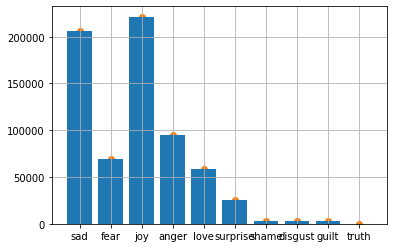

In [ ]:
emotions = df.emotion.unique()
sum_categorical_emotions = [df[df.emotion == i].size for i in emotions]
plt.bar(emotions, sum_categorical_emotions)
plt.scatter(emotions, sum_categorical_emotions)
plt.grid(True)
plt.show()

In [ ]:
df.head()


,emotion,content
87457,sad,i am dreading taking my first sip at the momen...
25450,fear,i am feeling pressured
45298,joy,i feel assured in my salvation does not grant ...
3837,sad,i have been feeling shitty sensitive and not g...
117570,joy,i also feel like i just need to be brave and t...


In [ ]:

df.loc[df.emotion == 'guilt', 'emotion'] = 'disgust'
df.loc[df.emotion == 'disgust', 'emotion'] = 'disgust'
df.loc[df.emotion == 'shame', 'emotion'] = 'disgust'
df.loc[df.emotion == 'joy', 'emotion'] = 'happiness'
df.loc[df.emotion == 'love', 'emotion'] = 'happiness'
df.loc[df.emotion == 'truth', 'emotion'] = 'truth'
df.emotion.unique()

array(['sad', 'fear', 'happiness', 'anger', 'surprise', 'disgust',
       'truth'], dtype=object)

[206492, 69616, 279488, 94636, 25302, 8714, 182]


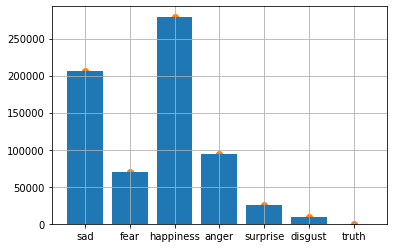

In [ ]:

emotions = df.emotion.unique()
sum_categorical_emotions = [df[df.emotion == i].size for i in emotions]
print(sum_categorical_emotions)
plt.bar(emotions, sum_categorical_emotions)
plt.scatter(emotions, sum_categorical_emotions)
plt.grid(True)
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

In [ ]:

sequences = tokenizer.texts_to_sequences(df['content'])
data = pad_sequences(sequences, maxlen=50)
X = data.reshape(len(data), 50)
X[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   3,  17,  43, 478], dtype=int32)

In [ ]:
flag = pd.Series(list(df['emotion']))
Y = pd.get_dummies(flag)
Y = np.array(Y)
Y[100]

array([0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
inputs = Input(shape=[50])
layer = Embedding(100000, 500, input_length=50)(inputs)
layer = LSTM(512)(layer)
layer = Dense(256)(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(7)(layer)
layer = Activation('softmax')(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 500)           50000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2074624   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799

In [ ]:
history=model.fit(X_train, y_train, batch_size=8192, epochs=10, validation_data=(X_test, y_test), shuffle=True)


Train on 229284 samples, validate on 112931 samples
Epoch 1/10
229284/229284 [==============================] - 3526s 15ms/step - loss: 1.4848 - accuracy: 0.3892 - val_loss: 1.3075 - val_accuracy: 0.4834
Epoch 2/10
229284/229284 [==============================] - 3501s 15ms/step - loss: 1.1501 - accuracy: 0.5797 - val_loss: 0.8422 - val_accuracy: 0.6961
Epoch 3/10
229284/229284 [==============================] - 3490s 15ms/step - loss: 0.6670 - accuracy: 0.7764 - val_loss: 0.4507 - val_accuracy: 0.8474
Epoch 4/10
229284/229284 [==============================] - 3479s 15ms/step - loss: 0.3717 - accuracy: 0.8801 - val_loss: 0.3132 - val_accuracy: 0.8955
Epoch 5/10
229284/229284 [==============================] - 3490s 15ms/step - loss: 0.3027 - accuracy: 0.8998 - val_loss: 0.2891 - val_accuracy: 0.9003
Epoch 6/10
229284/229284 [==============================] - 3465s 15ms/step - loss: 0.2819 - accuracy: 0.9046 - val_loss: 0.2739 - val_accuracy: 0.9042
Epoch 7/10
229284/229284 [=========

In [ ]:
model.save('master_model.h5')

In [ ]:
pickle.dump(history, open("history.p", "wb"))

In [ ]:

from keras.models import load_model
model = load_model('master_model.h5')

In [ ]:

statement = "i need assistance"
sequences = tokenizer.texts_to_sequences([statement])
data = pad_sequences(sequences, maxlen=50)
emotion = df.emotion.unique()
y = model.predict(data)
y = np.argmax(y)
print(emotion[y])

fear
